In [55]:
!pip install numpy pandas mediapipe tensorflow opencv-python matplotlib seaborn pyttsx3

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [2]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils


In [3]:
def extract_keypoints(image):
    """Extracts 33 keypoints from an image frame."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    
    keypoints = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            keypoints.append([landmark.x, landmark.y, landmark.z])
    
    return np.array(keypoints).flatten() if keypoints else np.zeros(99)


In [59]:
DATASET_PATH = "dataset"
OUTPUT_PATH = "extracted_keypoints"

os.makedirs(OUTPUT_PATH, exist_ok=True)

def process_video(video_path, save_path):
    cap = cv2.VideoCapture(video_path)
    frames_data = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        keypoints = extract_keypoints(frame)
        frames_data.append(keypoints.tolist())
    
    cap.release()
    
    with open(save_path, "w") as f:
        json.dump(frames_data, f)

# Process all videos
video_files = os.listdir(DATASET_PATH)
for video in video_files:
    process_video(os.path.join(DATASET_PATH, video), os.path.join(OUTPUT_PATH, f"{video.split('.')[0]}.json"))

print("Keypoint extraction completed!")


Keypoint extraction completed!


In [4]:
OUTPUT_PATH = "extracted_keypoints"
POSES = ["Anjaneyasana", "Bhujangasana", "Gomukhasana", "Paschimottanasana", "Vyaghrasana"]

X, y = [], []

for idx, pose_name in enumerate(POSES):
    for i in range(1, 5):  
        file_path = os.path.join(OUTPUT_PATH, f"{pose_name}_{i}.json")
        with open(file_path, "r") as f:
            data = json.load(f)
        
        for seq in data:
            X.append(seq)
            y.append(idx)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Loaded! Train size: {len(X_train)}, Test size: {len(X_test)}")


Data Loaded! Train size: 3708, Test size: 927


In [61]:
y_train_cat = to_categorical(y_train, num_classes=len(POSES))
y_test_cat = to_categorical(y_test, num_classes=len(POSES))

model = Sequential([
    Conv1D(filters=16, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(20, return_sequences=False),
    Dense(32, activation="relu"),
    Dense(len(POSES), activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=50, batch_size=16)

model.save("yoga_model.h5")
print("Model Training Complete & Saved!")


Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.2729 - loss: 1.6010 - val_accuracy: 0.3031 - val_loss: 1.5911
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.2936 - loss: 1.5814 - val_accuracy: 0.3020 - val_loss: 1.5773
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3105 - loss: 1.5583 - val_accuracy: 0.3182 - val_loss: 1.5687
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2989 - loss: 1.5529 - val_accuracy: 0.3290 - val_loss: 1.5546
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3054 - loss: 1.5269 - val_accuracy: 0.3625 - val_loss: 1.4983
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3711 - loss: 1.4583 - val_accuracy: 0.3808 - val_loss: 1.4076
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4122 - loss: 1.3720 - val_accuracy: 0.4466 - val_loss: 1.3718
Epoch 8/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4521 - loss: 1.3260 - val_accu

Model Training Complete & Saved!


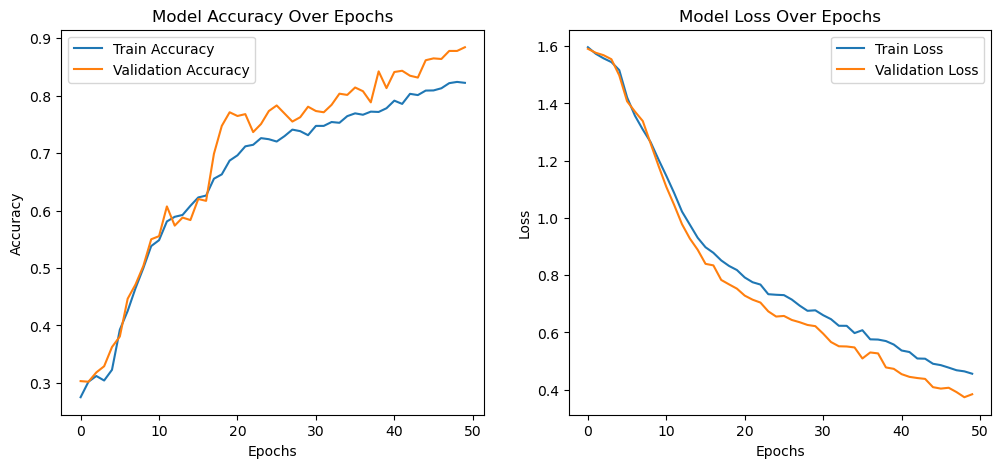

In [62]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [5]:
model = tf.keras.models.load_model("yoga_model.h5")


In [8]:
POSE_IMAGES = {
    "Anjaneyasana": "pose_images/Anjaneyasana.jpg",
    "Bhujangasana": "pose_images/Bhujangasana.jpg",
    "Gomukhasana": "pose_images/Gomukhasana.jpg",
    "Paschimottanasana": "pose_images/Paschimottanasana.jpg",
    "Vyaghrasana": "pose_images/Vyaghrasana.jpg",
}

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames_data = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        keypoints = extract_keypoints(frame)
        frames_data.append(keypoints.tolist())
    
    cap.release()
    return np.array(frames_data)

def predict_pose(video_path):
    keypoints = process_video(video_path)
    keypoints = keypoints.reshape(keypoints.shape[0], keypoints.shape[1], 1)
    
    predictions = model.predict(keypoints)
    predicted_labels = np.argmax(predictions, axis=1)
    
    final_prediction = np.bincount(predicted_labels).argmax()
    predicted_pose = POSES[final_prediction]

    avg_confidence = np.mean(predictions[:, final_prediction]) * 100
    
    return predicted_pose, avg_confidence, predictions

def show_pose_image(pose_name):
    """Displays the image of the predicted pose."""
    if pose_name in POSE_IMAGES:
        img_path = POSE_IMAGES[pose_name]
        img = cv2.imread(img_path)

        if img is not None:
            cv2.imshow(f"Predicted Pose: {pose_name}", img)
            cv2.waitKey(0)  # Wait until a key is pressed
            cv2.destroyAllWindows()
        else:
            print("⚠️ Pose image not found.")
    else:
        print("⚠️ No image available for this pose.")


test_video = "test_videos/sample_yoga_2.mp4"
predicted_pose, confidence, predictions = predict_pose(test_video)

print(f"🧘 Predicted Yoga Pose: {predicted_pose}")
print(f"✅ Prediction Confidence: {confidence:.2f}%")


show_pose_image(predicted_pose)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
🧘 Predicted Yoga Pose: Bhujangasana
✅ Prediction Confidence: 96.41%


In [7]:
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import MinMaxScaler

# Load extracted keypoints dataset to compute average pose keypoints
pose_keypoints_avg = {}

for idx, pose_name in enumerate(POSES):
    keypoints_list = []
    
    for i in range(1, 5):  # Assuming 4 samples per pose
        file_path = os.path.join(OUTPUT_PATH, f"{pose_name}_{i}.json")
        with open(file_path, "r") as f:
            data = json.load(f)
        
        keypoints_list.extend(data)  # Collect all keypoints of the pose
    
    pose_keypoints_avg[pose_name] = np.mean(keypoints_list, axis=0)  # Compute average keypoints

# Function to calculate pose correctness and injury risk
def evaluate_pose_correctness(video_keypoints, predicted_pose):
    avg_keypoints = pose_keypoints_avg.get(predicted_pose, None)
    
    if avg_keypoints is None:
        return "Unknown Pose", 0.0, "No reference data available"
    
    distances = [euclidean(avg_keypoints, frame) for frame in video_keypoints]  # Distance per frame
    avg_distance = np.mean(distances)  # Mean deviation
    
    # Normalize correctness score (lower distance = higher correctness)
    scaler = MinMaxScaler(feature_range=(0, 100))
    correctness_score = 100 - scaler.fit_transform(np.array([[avg_distance]])).flatten()[0]
    
    # Define risk of injury
    injury_risk = "Low"
    if correctness_score < 50:
        injury_risk = "High"
    elif correctness_score < 75:
        injury_risk = "Moderate"
    
    return correctness_score, injury_risk

# Test video evaluation
test_video = "test_videos/sample_yoga_2.mp4"
predicted_pose, confidence, predictions = predict_pose(test_video)

# Extract keypoints from the test video
video_keypoints = process_video(test_video)

# Evaluate correctness and injury risk
correctness_score, injury_risk = evaluate_pose_correctness(video_keypoints, predicted_pose)

print(f"🎯 Pose Correctness Score: {correctness_score:.2f}%")
print(f"⚠️ Risk of Injury: {injury_risk}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
🎯 Pose Correctness Score: 100.00%
⚠️ Risk of Injury: Low


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


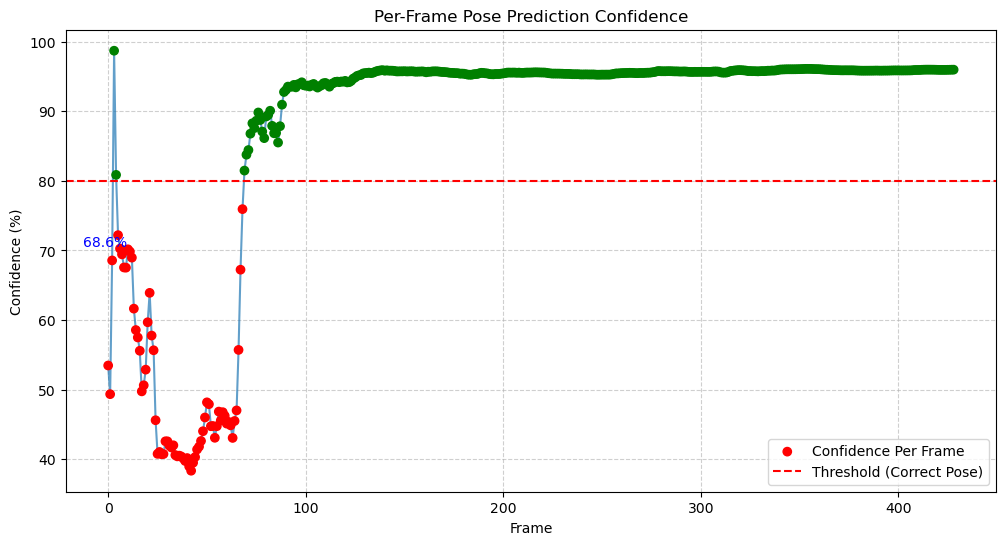

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define confidence threshold
THRESHOLD = 80  

# Use real predictions from the model
test_video = "test_videos/sample_yoga_4.mp4"
_, _, predictions = predict_pose(test_video)  # Extract frame-wise confidence
frame_confidences = np.max(predictions, axis=1) * 100  # Convert to percentage

# Identify sudden drops/spikes (large changes in confidence)
confidence_changes = np.abs(np.diff(frame_confidences))
sudden_changes = np.where(confidence_changes > 20)[0]  # Frames with large confidence jumps

# Colorize confidence points
colors = ["green" if conf > THRESHOLD else "red" for conf in frame_confidences]

# Plot confidence graph
plt.figure(figsize=(12, 6))
plt.scatter(range(len(frame_confidences)), frame_confidences, c=colors, label="Confidence Per Frame", zorder=3)
plt.plot(range(len(frame_confidences)), frame_confidences, linestyle="-", alpha=0.7, zorder=2)

# Draw threshold line
plt.axhline(y=THRESHOLD, color="r", linestyle="--", label="Threshold (Correct Pose)")

# Add annotations for sudden drops/spikes
for idx in sudden_changes:
    plt.annotate(f"{frame_confidences[idx]:.1f}%", (idx, frame_confidences[idx]), textcoords="offset points", xytext=(-5,10), ha='center', fontsize=10, color="blue")

# Labels & title
plt.xlabel("Frame")
plt.ylabel("Confidence (%)")
plt.title("Per-Frame Pose Prediction Confidence")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()
